In [82]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from IPython.display import clear_output
from kan import *
from app import cat_features, pca_pipeline, lag_features

device = 'cuda' if torch.cuda.is_available() else 'cpu'

![KAN](https://habrastorage.org/r/w1560/getpro/habr/upload_files/0df/035/99e/0df03599e984071a838e5b2957c662b8.png)

In [83]:
data = pd.read_csv('df_general.csv')
pd.set_option('display.max_columns', None) 
data[lag_features] = data[lag_features].fillna(999)
data.fillna(0, inplace=True)

In [84]:
epoch = 180
input_size = 20
output_size = 3

In [85]:
train = data[data['gameweek_compSeason_label'] != 2023]
test = data[data['gameweek_compSeason_label'] == 2023]

X_train = train.drop('team_1_hue', axis=1)
y_train = train['team_1_hue']

cat_cols = cat_features(X_train)
num_cols = list(set(X_train.columns.tolist()) - set(cat_cols))

X_test = test.drop('team_1_hue', axis=1)
y_test = test['team_1_hue']

X_train, pipeline = pca_pipeline(X_train, y_train, cat_cols, num_cols, n_components=input_size ,pca=True)
X_test = pipeline.transform(X_test)

In [86]:
X_train.shape, X_test.shape

((3420, 20), (380, 20))

In [87]:
dataset = {}

dataset['train_input'] = torch.tensor(X_train, dtype=torch.float32)
dataset['train_label'] = torch.tensor(list(y_train), dtype=torch.int16).long()
dataset['test_input'] = torch.tensor(X_test, dtype=torch.float32)
dataset['test_label'] = torch.tensor(list(y_test), dtype=torch.int16).long()

In [88]:
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([3420, 20]), torch.Size([3420]))

In [89]:
model = KAN(width=[input_size, input_size*2, output_size], grid=9, k=3, seed=0, device=device)

In [90]:

def f1_macro_train():
    return f1_score(dataset['train_label'].cpu().numpy(), torch.argmax(model(dataset['train_input'].to(device)), dim=1).cpu().numpy(), average='macro')

def f1_macro_test():
    return f1_score(dataset['test_label'].cpu().numpy(), torch.argmax(model(dataset['test_input'].to(device)), dim=1).cpu().numpy(), average='macro')

results = model.train(dataset,
                      opt="LBFGS",
                      steps=epoch,
                      metrics=(f1_macro_train, f1_macro_test),
                      device=device, loss_fn=torch.nn.CrossEntropyLoss())

train loss: 9.86e-01 | test loss: 1.03e+00 | reg: 3.67e+01 : 100%|█| 180/180 [12:18<00:00,  4.10s/it


In [91]:
acc = accuracy_score(dataset['test_label'], torch.argmax(model(dataset['test_input'].to(device)), dim=1).cpu().detach().numpy())
f1_weighted = f1_score(dataset['test_label'], torch.argmax(model(dataset['test_input'].to(device)), dim=1).cpu().detach().numpy(), average='weighted')
f1_macro = f1_score(dataset['test_label'], torch.argmax(model(dataset['test_input'].to(device)), dim=1).cpu().detach().numpy(), average='macro')
print(f'Accuracy: {acc:.3f}\nf1_weighted: {f1_weighted:.3f}\nf1_macro: {f1_macro:.3f}')

Accuracy: 0.576
f1_weighted: 0.530
f1_macro: 0.464


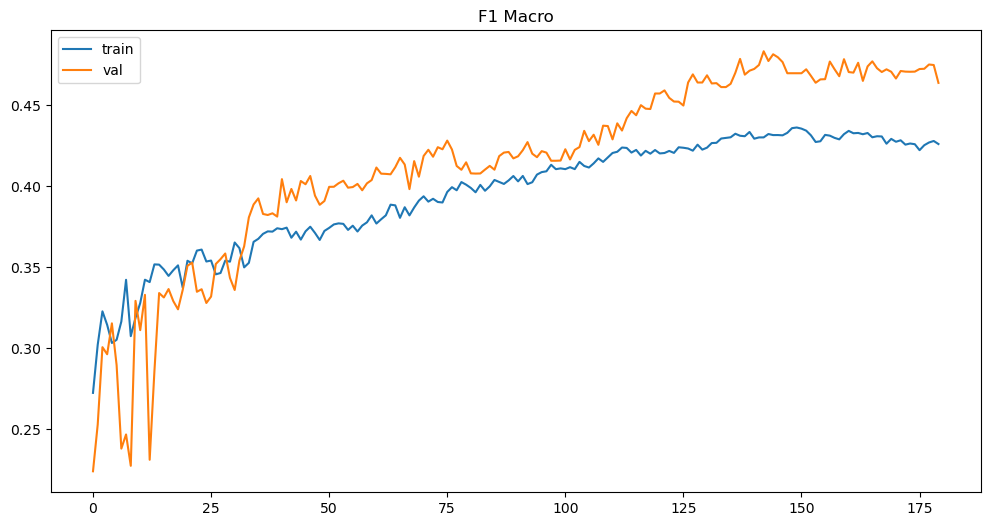

In [92]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.plot(range(epoch), results['f1_macro_train'], label='train')
axs.plot(range(epoch), results['f1_macro_test'], label='val')
axs.set_title('F1 Macro')
axs.legend()

plt.show()

## Class weight

In [93]:
from sklearn.utils.class_weight import compute_class_weight

y_train_np = dataset['train_label'].numpy()
class_weights = compute_class_weight(class_weight='balanced', classes=torch.unique(dataset['train_label']).numpy(), y=y_train_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights_tensor

tensor([1.0526, 0.7436, 1.4179], device='cuda:0')

In [94]:
model = KAN(width=[input_size, input_size*2, output_size], grid=9, k=3, seed=0, device=device)

results = model.train(dataset, opt="LBFGS",
                      steps=epoch,
                      metrics=(f1_macro_train, f1_macro_test),
                      device=device,
                      loss_fn=torch.nn.CrossEntropyLoss(weight=class_weights_tensor))

train loss: 1.01e+00 | test loss: 2.41e+00 | reg: 3.66e+01 : 100%|█| 180/180 [11:51<00:00,  3.95s/it


In [95]:
acc = accuracy_score(dataset['test_label'], torch.argmax(model(dataset['test_input'].to(device)), dim=1).cpu().detach().numpy())
f1_weighted = f1_score(dataset['test_label'], torch.argmax(model(dataset['test_input'].to(device)), dim=1).cpu().detach().numpy(), average='weighted')
f1_macro = f1_score(dataset['test_label'], torch.argmax(model(dataset['test_input'].to(device)), dim=1).cpu().detach().numpy(), average='macro')
print(f'Accuracy: {acc:.3f}\nf1_weighted: {f1_weighted:.3f}\nf1_macro: {f1_macro:.3f}')

Accuracy: 0.526
f1_weighted: 0.522
f1_macro: 0.484


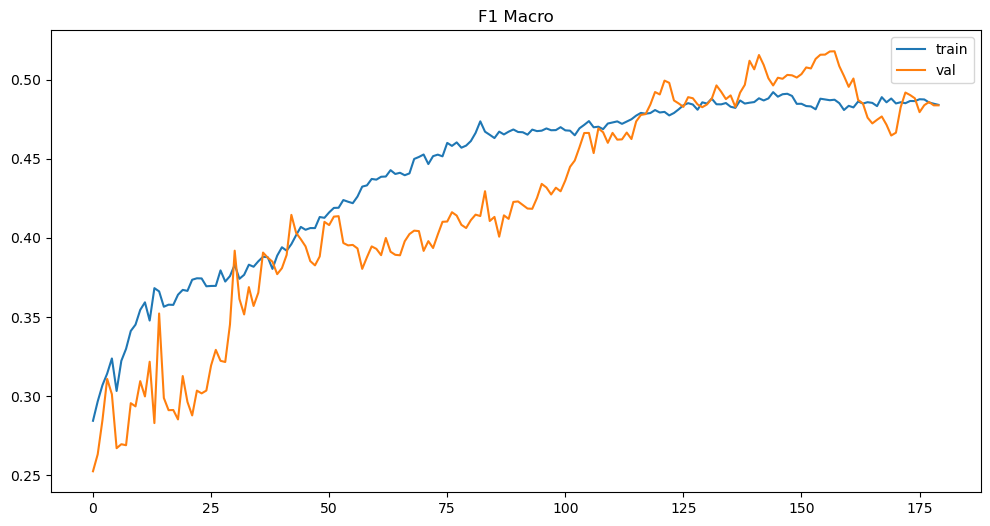

In [96]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

axs.plot(range(epoch), results['f1_macro_train'], label='train')
axs.plot(range(epoch), results['f1_macro_test'], label='val')
axs.set_title('F1 Macro')
axs.legend()

plt.show()